In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn import preprocessing as pre
import keras
import tensorflow.keras.backend as K
import copy

2024-06-19 17:28:25.036410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 17:28:26.351870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# df_0_noise = pd.read_csv('inputs/16_Devices_0_noise_20240228_17_34_06.csv', sep=', ')

# # axs = df_0_noise.plot.area(figsize=(12, 10), subplots=True)
# axs = df_0_noise['Ch1(mA)'][:400].plot(figsize=(12, 4))

/tmp/ipykernel_196462/1652506205.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_20_noise = pd.read_csv('inputs/16_Devices_20_noise_20240228_15_42_05.csv', sep=', ')


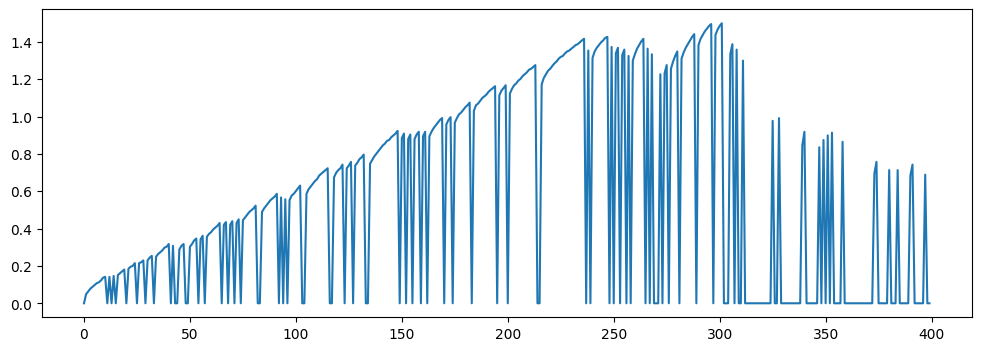

In [3]:
df_20_noise = pd.read_csv('inputs/16_Devices_20_noise_20240228_15_42_05.csv', sep=', ')
axs = df_20_noise['Ch1(mA)'][:400].plot(figsize=(12, 4))

In [4]:
# df_50_noise = pd.read_csv('inputs/16_Devices_50_Noise_20240409_11_40_06.csv', sep=', ')
# axs = df_50_noise['Ch1(mA)'][:400].plot(figsize=(12, 4))

In [5]:
# df_list = np.array_split(df,len(index_list))


In [6]:
# df_list[0].shape

Set model to use and simulate for given inputs

In [7]:
number_models = 2

index_list = [0,]
array_size = 100

In [8]:
import functions
load = True
model_path = np.empty((number_models,), dtype='U60')
baseline_current_array = np.empty((number_models,), dtype='U60')

# model_path[0] ='models/2024-04-17_12-35-13_single_step_41/model.h5'
# baseline_current_array[0] = 0.93971

model_path[0] ='models/2024-05-14_18-50-13_single_step_v2/model.h5'
baseline_current_array[0] = 1.1841702461242676


model_path[1] ='models/2024-05-14_21-43-39_single_step_v3/model.h5'
baseline_current_array[1] = 1.787




In [9]:
model_path

array(['models/2024-05-14_18-50-13_single_step_v2/model.h5',
       'models/2024-05-14_21-43-39_single_step_v3/model.h5'], dtype='<U60')

In [10]:
# measurements start from C =0
baseline_current_array = np.zeros_like(baseline_current_array, dtype=float)
base_on_time= 100
on_time = 50
off_time= 20

In [11]:
x_train  = copy.deepcopy(df_20_noise['Ch1(mA)'])
x_train[x_train!= 0] = 1
x_train = x_train.to_numpy()
x_train = x_train[np.newaxis,:]
x_train = x_train[:,:array_size ]
x_train.shape


(1, 100)

In [13]:
for i in range(model_path.shape[0]):
    model = keras.models.load_model(model_path[i])        
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
simulated_current_array = np.zeros((len(index_list),number_models, array_size))
for j, index in enumerate(index_list):
    for i in range(model_path.shape[0]):
        model = keras.models.load_model(model_path[i])
        baseline_current = baseline_current_array[i]
        functions.baseline_current = baseline_current
        functions.model = model
        
        simulated_current, _,_ = functions.pixel_to_signal_array(x_train, base_on_time, on_time, off_time, modulation=1, max_int=1, linearize=False)



        simulated_current_array[j,i] = simulated_current



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
1/1 [==============================] - 0s 16ms/step


Plot comparison

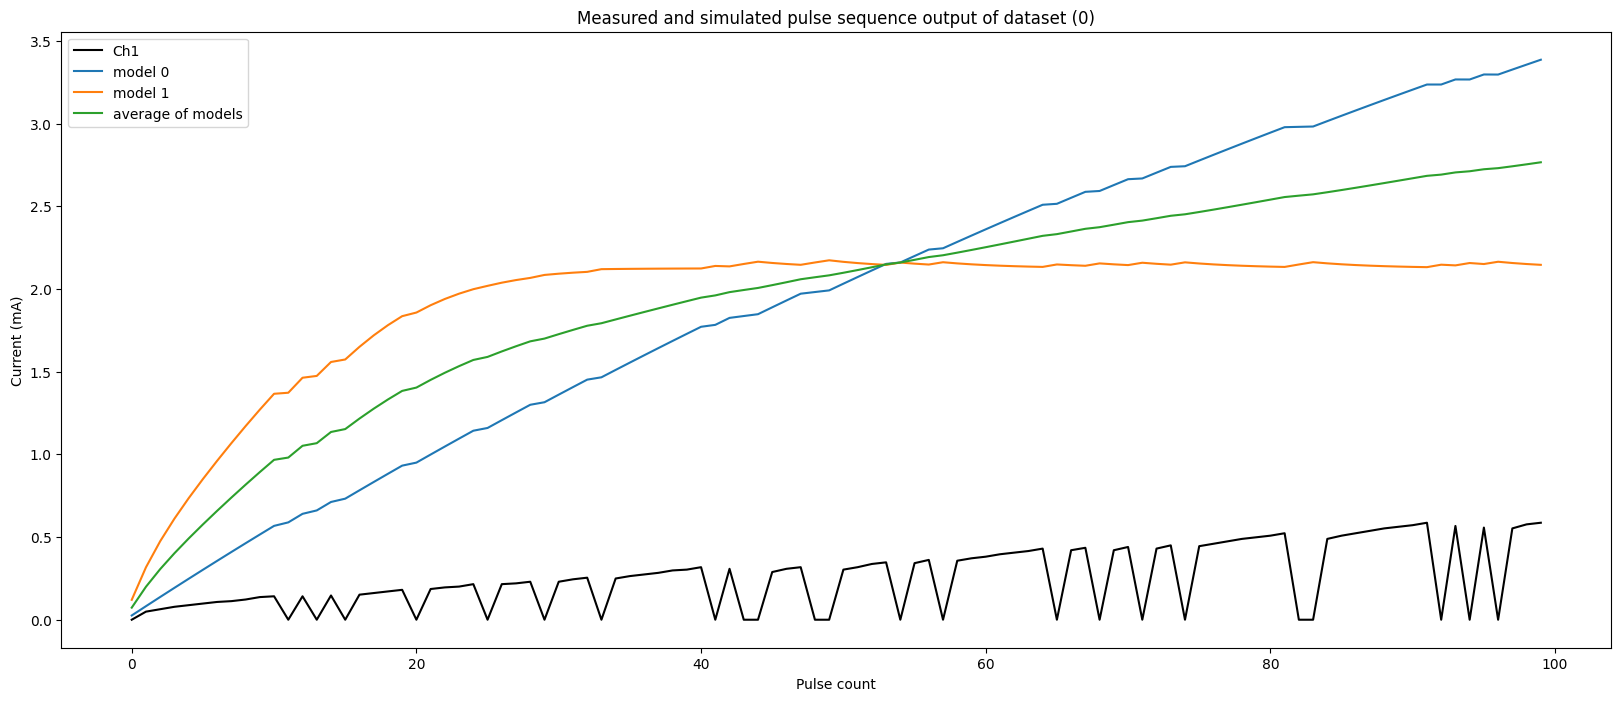

In [ ]:
fig, axs = plt.subplots(len(index_list),sharex= True, figsize=(20,8))

for j, index in enumerate(index_list):

 
   
   axs.plot(range(array_size),df_20_noise[f'Ch{index+1}(mA)'][:array_size ], linestyle='-',alpha=1, color = 'black',label = f'Ch{i}') 


   # plot simulation
   for i in range(model_path.shape[0]):
      axs.plot(range(array_size),simulated_current_array[j,i], linestyle='-',label = f'model {i}', )
   axs.plot(range(array_size),simulated_current_array[j,0]/2+simulated_current_array[j,1]/2, linestyle='-',label = f'average of models', )

   axs.set_title(f'Measured and simulated pulse sequence output of dataset ({index})')
   axs.set_ylabel('Current (mA)')
   axs.set_xlabel('Pulse count')
   axs.legend()
# for ax in axs:
   axs.label_outer()

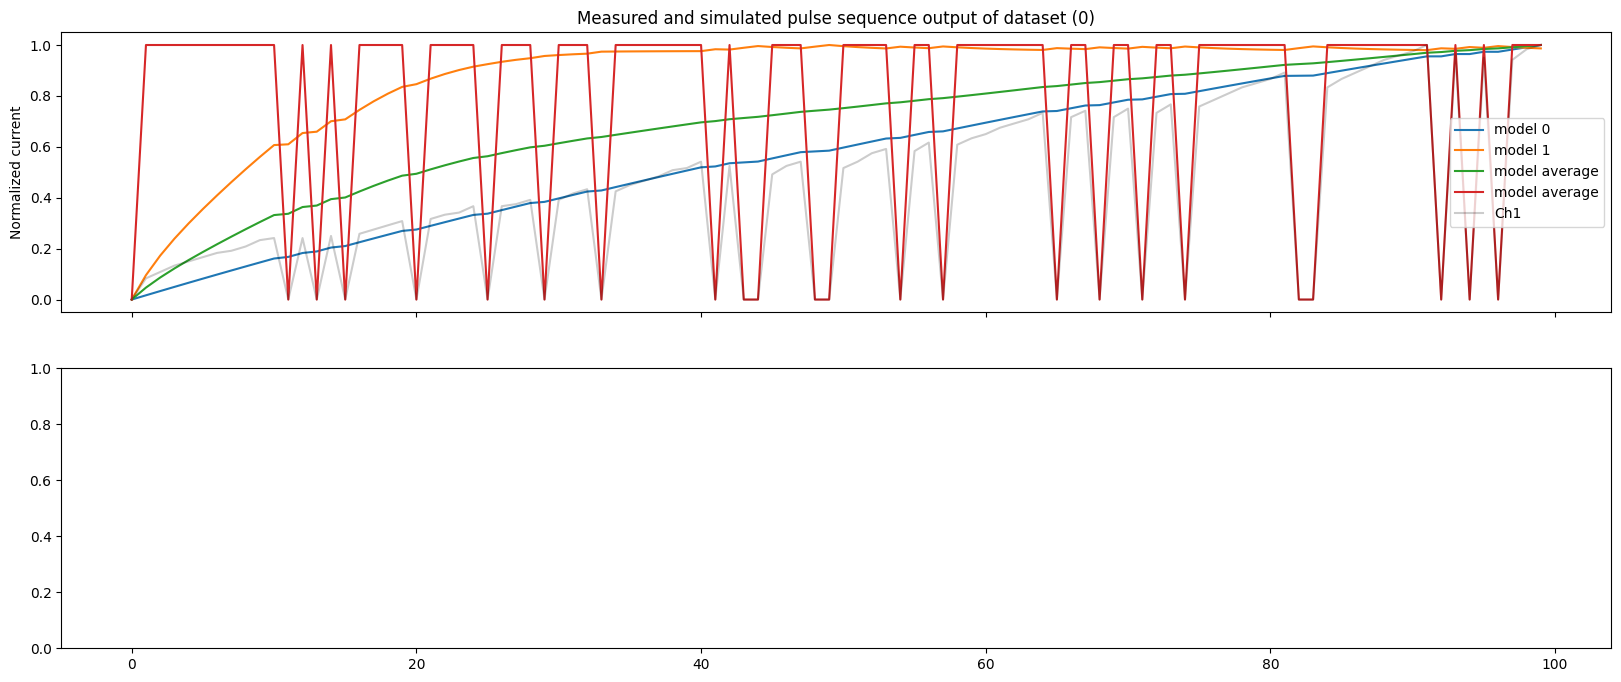

In [ ]:
fig, axs = plt.subplots(len(index_list)+1,sharex= True, figsize=(20,8))

for j, index in enumerate(index_list):
   # plot simulation  
   for i in range(model_path.shape[0]):
      axs[j].plot(range(array_size),pre.minmax_scale(simulated_current_array[j,i]), linestyle='-',label = f'model {i}' )
     
   axs[j].plot(range(array_size),pre.minmax_scale(simulated_current_array[j,0]/2+simulated_current_array[j,1]/2), linestyle='-',label = f'model average', )
   axs[j].plot(range(array_size),x_train[0], linestyle='-',label = f'model average', )
   # plot data
   
   axs[j].plot(range(array_size),pre.minmax_scale(df_20_noise[f'Ch{index+1}(mA)'][:array_size ]),alpha=0.2, color = 'black',label = f'Ch{i}') #
   axs[j].set_ylabel('Normalized current')
   axs[j].set_title(f'Measured and simulated pulse sequence output of dataset ({index})')
   axs[j].set_xlabel('Pulse count')
   axs[j].legend()
for ax in axs.flat:
    ax.label_outer()

